# CIFAR

In [ ]:
%matplotalib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Why we use CIFAR dataset 

1. CIFAR : very small images and low number of images. 
2. Quick turnaround if we are working on CIFAR rather than imagenette

In [ ]:
from fastai2.basics import *
from fastai2.callback.all import *
from fastai2.vision.all import *

from fastai2.data.all import *
from fastai2.vision.core import *
from fastai2.vision.data import *
from dlnotebooks.models.simplecnn import *
import matplotlib.pyplot as plt

from fastai2.callback import *


# Gathering the data

We will download the data from fastai repository. It's a convenient method to collect the samples

In [ ]:
source = untar_data(URLs.CIFAR)
images = get_image_files(source)
fn = images[0];fn

Path('C:/Users/t158185/.fastai/data/cifar10/test/airplane/1001_airplane.png')

# Create data source

Data source consists of adding transformation for items and assign it to either X or Y. In our case, we will define two transformations

1. Load the image and call it X
2. Load the path , extract label and call it Y

In [ ]:
labeller = RegexLabeller(pat = r'.*?[\\/](\w+)[\\/]\d+_\w+.png$') # parent_label
labeller(fn)

'airplane'

In [ ]:
class ImageResizer(Transform):
    order =0
    "Resize the image using resample"
    def __init__(self, size, resample=Image.BILINEAR):
        if not is_listy(size): self.size=(size, size)
        self.size, self.resample = size, resample
        
    def encodes(self, o:PILImage): return o.resize(size=self.size, resample = self.resample)
    def encodes(self, o:PILMask): return o.resize(size=self.size, resample=Image.NEAREST)
    

In [ ]:
tfms =[[PILImage.create ], [labeller, Categorize() ]]
dsrc = DataSource(images, tfms)

In [ ]:
dsrc.categorize.vocab

(#10) ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [ ]:
#hide
t = dsrc[0]
type(t[0]), type(t[1])

(fastai2.vision.core.PILImage, fastai2.torch_core.TensorCategory)

In [ ]:
x, y = dsrc.decode(t)

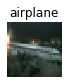

In [ ]:
dsrc.show(t)

# Data Loader

After we are satisfied with the data, we can load the data in memory using batch.

In [ ]:
tdl = TfmdDL(dsrc, bs=16, after_item=[ImageResizer((32,32)), ToTensor(), IntToFloatTensor()])

t = tdl.one_batch()
x, y = tdl.decode_batch(t)[0]
x.shape, y

(torch.Size([3, 32, 32]), 'airplane')

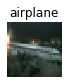

In [ ]:
dsrc.show((x, y))

In [ ]:
split_idx = RandomSplitter()(images)
tfms =[[PILImage.create ], [labeller, Categorize() ]]
dsrc = DataSource(images, tfms, splits=split_idx)

dbunch = dsrc.databunch(bs=16, after_item=[ImageResizer((32,32)), ToTensor(), IntToFloatTensor()], num_workers=0)

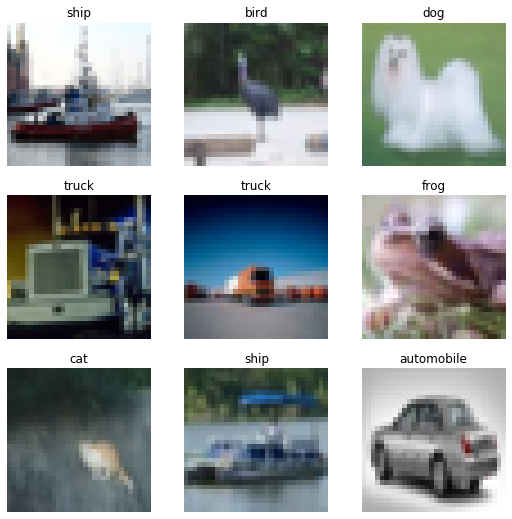

In [ ]:
dbunch.show_batch()

# Simple Linear Connected

# Simple 

# Learner

In [ ]:
xb, yb = dbunch.one_batch()
xb.type()

'torch.cuda.FloatTensor'

In [ ]:
model = SimpleCNN().cuda()
score =model(xb)

C:\Users\t158185\Documents\GitHub\dl-notebooks\dlnotebooks\models\simplecnn.py:45: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(x)


In [ ]:
score.shape

torch.Size([16, 10])

In [ ]:
learn = Learner(dbunch, model , loss_func=LabelSmoothingCrossEntropy(), metrics=[accuracy], cb_funcs =[MixUp] ).to_fp16()

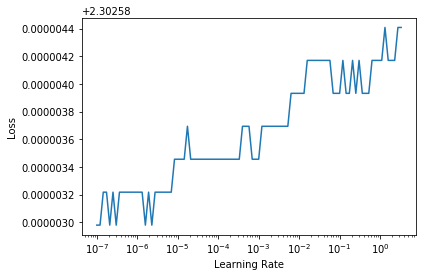

In [ ]:
learn.lr_find()

In [ ]:
learn.fit_one_cycle(3, lr_max=10e-3 )

epoch,train_loss,valid_loss,accuracy,time


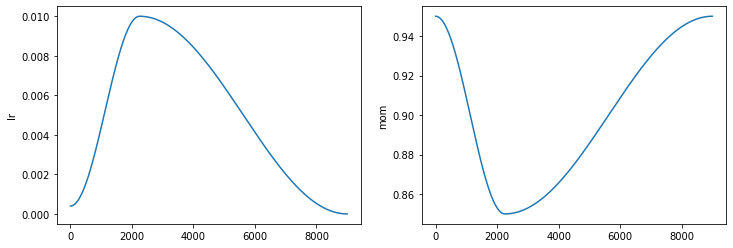

In [ ]:
learn.recorder.plot_sched()